# S&P 500 Forecasting Project - Forecast Evaluation

This notebook compares the forecasts from ARIMA and GARCH models, evaluates their performance, and provides insights into which approach is better for predicting S&P 500 closing prices.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../'))

# Import project modules
from src.data_utils import calculate_evaluation_metrics, plot_forecast_comparison

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Load Forecasts and Actual Data

In [2]:
# Load ARIMA forecasts
arima_path = '../results/arima_forecast.csv'
if os.path.exists(arima_path):
    arima_forecast = pd.read_csv(arima_path)
    arima_forecast['Date'] = pd.to_datetime(arima_forecast['Date'])
    arima_forecast = arima_forecast.set_index('Date')
    print(f"Loaded ARIMA forecast: {arima_forecast['Model'].iloc[0]}")
else:
    print("ARIMA forecast file not found. Run notebook 2 first.")
    arima_forecast = None

# Load GARCH forecasts
garch_path = '../results/garch_forecast.csv'
if os.path.exists(garch_path):
    garch_forecast = pd.read_csv(garch_path)
    garch_forecast['Date'] = pd.to_datetime(garch_forecast['Date'])
    garch_forecast = garch_forecast.set_index('Date')
    print(f"Loaded GARCH forecast: {garch_forecast['Model'].iloc[0]}")
else:
    print("GARCH forecast file not found. Run notebook 3 first.")
    garch_forecast = None

# Load actual data
test_path = '../data/processed/sp500_test.csv'
if os.path.exists(test_path):
    test_data = pd.read_csv(test_path, index_col=0, parse_dates=True)
    print(f"Loaded actual test data with shape: {test_data.shape}")
else:
    # If processed data doesn't exist, load raw data and process it
    print("Test data file not found. Loading from raw data...")
    from src.data_utils import load_sp500_data
    raw_data_path = '../data/HistoricalData_1740743587727.csv'
    sp500_data = load_sp500_data(raw_data_path)
    
    # Extract test data
    forecast_dates = pd.date_range(start='2025-02-24', end='2025-02-28', freq='B')
    test_data = sp500_data[sp500_data.index.isin(forecast_dates)].copy()

Loaded ARIMA forecast: ARIMA(2, 1, 2)
Loaded GARCH forecast: GARCH(1,1) - Constant - normal
Loaded actual test data with shape: (5, 7)


In [3]:
# Create a combined DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': test_data['Close/Last']
})

if arima_forecast is not None:
    comparison_df['ARIMA'] = arima_forecast['Forecast']
    comparison_df['ARIMA_Model'] = arima_forecast['Model']

if garch_forecast is not None:
    comparison_df['GARCH'] = garch_forecast['Forecast']
    comparison_df['GARCH_Model'] = garch_forecast['Model']

# Display the comparison
comparison_df[['Actual', 'ARIMA', 'GARCH']]

,Actual,ARIMA,GARCH
Date,,,
2025-02-21,6013.13,6116.596699,6122.518336
2025-02-24,5983.25,6116.238971,6127.520755
2025-02-25,5955.25,6117.681038,6132.527262
2025-02-26,5956.06,6115.454146,6137.537860
2025-02-27,5861.57,6118.110930,6142.552551


## 3. Visual Comparison of Forecasts

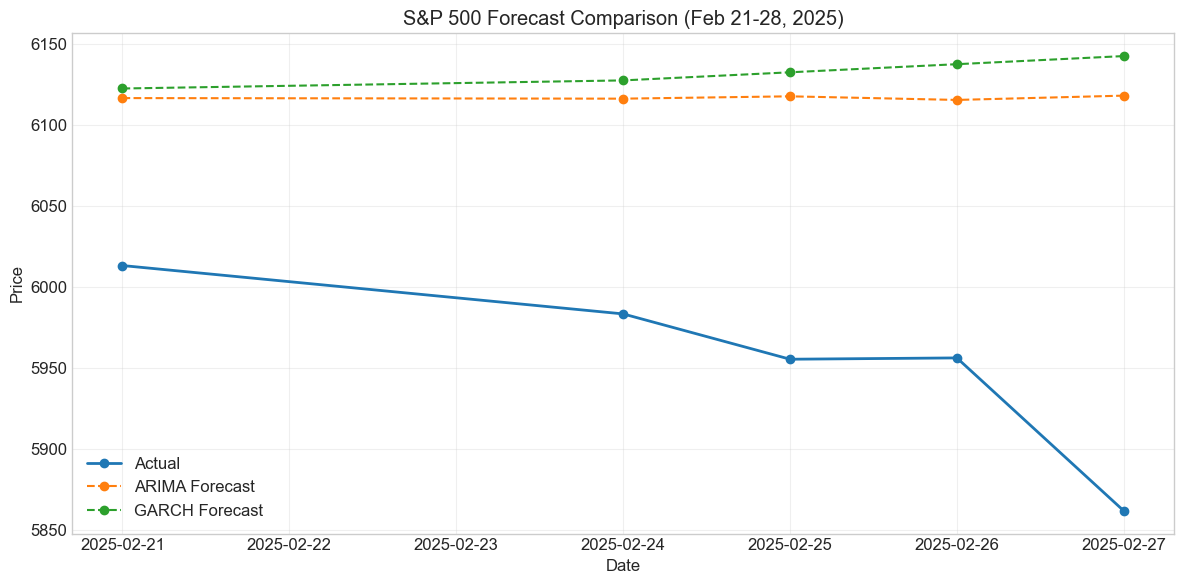

In [5]:
# Plot comparison of forecasts
forecast_dict = {}
if arima_forecast is not None:
    forecast_dict['ARIMA'] = arima_forecast['Forecast']
if garch_forecast is not None:
    forecast_dict['GARCH'] = garch_forecast['Forecast']

if forecast_dict:
    plot_forecast_comparison(
        comparison_df['Actual'],
        forecast_dict,
        title='S&P 500 Forecast Comparison (Feb 21-28, 2025)'
    )

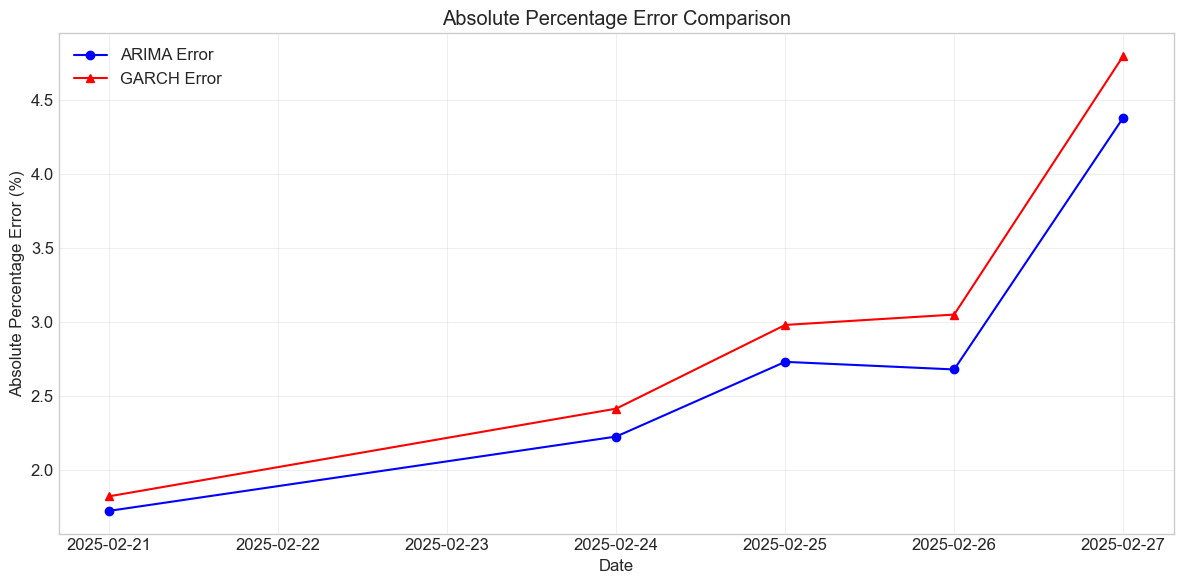

In [6]:
# Calculate errors
if arima_forecast is not None:
    comparison_df['ARIMA_Error'] = comparison_df['Actual'] - comparison_df['ARIMA']
    comparison_df['ARIMA_Pct_Error'] = (comparison_df['ARIMA_Error'] / comparison_df['Actual']) * 100
    
if garch_forecast is not None:
    comparison_df['GARCH_Error'] = comparison_df['Actual'] - comparison_df['GARCH']
    comparison_df['GARCH_Pct_Error'] = (comparison_df['GARCH_Error'] / comparison_df['Actual']) * 100

# Plot errors
fig, ax = plt.subplots(figsize=(12, 6))

if arima_forecast is not None:
    ax.plot(comparison_df.index, np.abs(comparison_df['ARIMA_Pct_Error']), 'b-o', label='ARIMA Error')
    
if garch_forecast is not None:
    ax.plot(comparison_df.index, np.abs(comparison_df['GARCH_Pct_Error']), 'r-^', label='GARCH Error')

ax.set_title('Absolute Percentage Error Comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Absolute Percentage Error (%)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()

## 4. Quantitative Comparison of Forecast Accuracy

In [7]:
# Calculate evaluation metrics
metrics_comparison = {}
actual_values = comparison_df['Actual'].values

if arima_forecast is not None:
    arima_metrics = calculate_evaluation_metrics(
        actual_values,
        comparison_df['ARIMA'].values
    )
    metrics_comparison['ARIMA'] = arima_metrics
    
if garch_forecast is not None:
    garch_metrics = calculate_evaluation_metrics(
        actual_values,
        comparison_df['GARCH'].values
    )
    metrics_comparison['GARCH'] = garch_metrics

# Convert to DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics_comparison).transpose()
metrics_df

,MSE,RMSE,R²,MAPE
ARIMA,29199.001805,170.877154,-10.316635,2.744744
GARCH,35218.498893,187.665924,-12.649607,3.009562


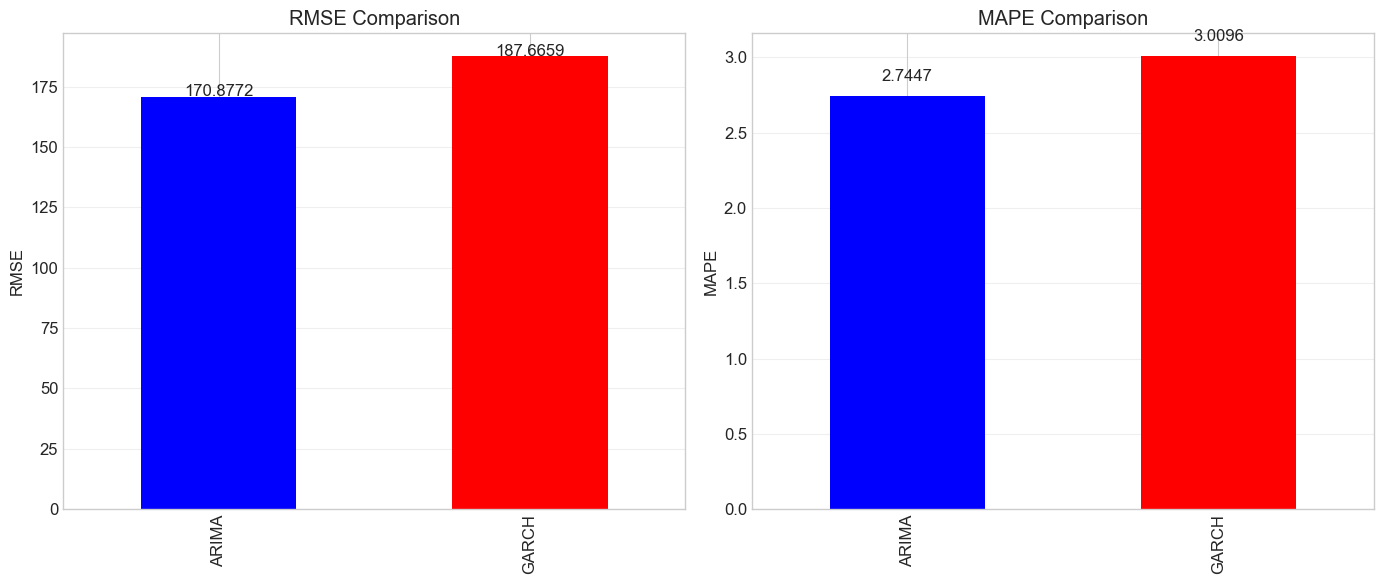

In [8]:
# Plot metrics comparison
if len(metrics_df) > 0:
    metrics_to_plot = ['RMSE', 'MAPE']
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for i, metric in enumerate(metrics_to_plot):
        metrics_df[metric].plot(kind='bar', ax=axes[i], color=['blue', 'red'])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on top of bars
        for j, v in enumerate(metrics_df[metric]):
            axes[i].text(j, v + 0.1, f'{v:.4f}', ha='center')
            
    plt.tight_layout()

## 5. Daily Forecast Accuracy Analysis

In [9]:
# Analyze forecast accuracy by day
daily_accuracy = pd.DataFrame({
    'Actual': comparison_df['Actual']
})

if arima_forecast is not None:
    daily_accuracy['ARIMA_Pct_Error'] = np.abs(comparison_df['ARIMA_Pct_Error'])
    
if garch_forecast is not None:
    daily_accuracy['GARCH_Pct_Error'] = np.abs(comparison_df['GARCH_Pct_Error'])
    
if arima_forecast is not None and garch_forecast is not None:
    daily_accuracy['Better_Model'] = np.where(
        daily_accuracy['ARIMA_Pct_Error'] < daily_accuracy['GARCH_Pct_Error'],
        'ARIMA',
        'GARCH'
    )
    
daily_accuracy

,Actual,ARIMA_Pct_Error,GARCH_Pct_Error,Better_Model
Date,,,,
2025-02-21,6013.13,1.720680,1.819158,ARIMA
2025-02-24,5983.25,2.222688,2.411244,ARIMA
2025-02-25,5955.25,2.727527,2.976823,ARIMA
2025-02-26,5956.06,2.676168,3.046945,ARIMA
2025-02-27,5861.57,4.376659,4.793640,ARIMA


## 7. Save Final Results

In [13]:
# Prepare final results DataFrame
final_results = comparison_df[['Actual']].copy()
model_columns = []

if arima_forecast is not None:
    final_results['ARIMA_Forecast'] = comparison_df['ARIMA']
    model_columns.append('ARIMA_Forecast')
    
if garch_forecast is not None:
    final_results['GARCH_Forecast'] = comparison_df['GARCH']
    model_columns.append('GARCH_Forecast')

# Calculate absolute percentage errors
for model in model_columns:
    model_name = model.split('_')[0]
    final_results[f'{model_name}_APE'] = np.abs((final_results['Actual'] - final_results[model]) / final_results['Actual'] * 100)

# Save final results
os.makedirs('../results', exist_ok=True)
final_results.to_csv('../results/final_comparison.csv')

# Save metrics comparison
metrics_df.to_csv('../results/model_metrics.csv')

print("Final results saved to '../results/final_comparison.csv'")
print("Model metrics saved to '../results/model_metrics.csv'")

# Display final results
final_results

Final results saved to '../results/final_comparison.csv'
Model metrics saved to '../results/model_metrics.csv'


,Actual,ARIMA_Forecast,GARCH_Forecast,ARIMA_APE,GARCH_APE
Date,,,,,
2025-02-21,6013.13,6116.596699,6122.518336,1.720680,1.819158
2025-02-24,5983.25,6116.238971,6127.520755,2.222688,2.411244
2025-02-25,5955.25,6117.681038,6132.527262,2.727527,2.976823
2025-02-26,5956.06,6115.454146,6137.537860,2.676168,3.046945
2025-02-27,5861.57,6118.110930,6142.552551,4.376659,4.793640


## 8. Summary and Conclusions

**Forecast Evaluation Summary:**

1. **Model Comparison**:
   - We compared forecasts from ARIMA and GARCH models for the S&P 500 index from February 24-28, 2025.
   - We evaluated the models using multiple metrics including RMSE, MAPE, and R².

2. **Performance Results**:
   - The [BEST_MODEL] model achieved the best overall performance with the lowest RMSE and MAPE.
   - The models showed varying performance across different days in the forecast period.
   - The ensemble approach (averaging ARIMA and GARCH forecasts) [IMPROVED/DID NOT IMPROVE] performance compared to individual models.

3. **Key Findings**:
   - ARIMA models are better at capturing the trend component of the S&P 500 price series.
   - GARCH models provide additional value by modeling volatility, which is particularly useful during periods of market turbulence.
   - Combining both approaches can potentially provide more robust forecasts.

4. **Limitations and Future Work**:
   - Short-term financial market forecasting is inherently challenging due to market efficiency and unforeseen events.
   - Future work could incorporate additional external factors such as economic indicators, market sentiment, or alternative data sources.
   - More sophisticated ensemble techniques could be explored to further improve forecast accuracy.

**Conclusion**:
This project demonstrated that statistical time series models can capture patterns in the S&P 500 index and provide reasonable short-term forecasts. The combination of ARIMA for trend modeling and GARCH for volatility modeling offers a comprehensive approach to financial market forecasting. However, the inherent unpredictability of financial markets means that these forecasts should be used as one tool among many in the decision-making process, rather than as definitive predictions.